In [48]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.copy_on_write = True

In [5]:
#import alliances data
df_raw= pd.read_csv("alliance_v4.1_by_directed.csv")
Alliances.head()

,version4id,ccode1,state_name1,ccode2,state_name2,dyad_st_day,dyad_st_month,dyad_st_year,dyad_end_day,dyad_end_month,dyad_end_year,left_censor,right_censor,defense,neutrality,nonaggression,entente,version
0,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,NaN,1,1,1,0,1.0,0.0,4.1
1,1,235,Portugal,200,United Kingdom,1,1,1816,NaN,NaN,NaN,1,1,1,0,1.0,0.0,4.1
2,2,200,United Kingdom,380,Sweden,1,1,1816,15.0,2.0,1911.0,1,0,0,0,0.0,1.0,4.1
3,2,380,Sweden,200,United Kingdom,1,1,1816,15.0,2.0,1911.0,1,0,0,0,0.0,1.0,4.1
4,3,240,Hanover,245,Bavaria,1,1,1838,15.0,3.0,1848.0,0,0,1,0,1.0,1.0,4.1


In [64]:
#remove shit we don't care about
dfpp=df_raw.drop(labels=list(['version4id','left_censor','right_censor','nonaggression','version','neutrality']),axis=1)
#filter out aliances where we don't know the end or start day's
#solution to use notna from stack overflow
df_clean1 = dfpp[dfpp['dyad_st_day'].notna()]
df=df_clean1[df_clean1['dyad_end_day'].notna()]
#convert to a date code
def datecode(year,month,day):
    datecode=year*365.25+month*30+day
    return datecode

starts=[]
ends=[]
#nessacary for iteration below
df.reset_index(drop=True,inplace=True)
for i in range(0,len(df)):
    #filter out non-defense non-entente alliances
    if not (df['defense'][i]==1.0 or df['entente'][i]==1):
        #print('')
        df.drop(i,axis=0,inplace=True)
df.reset_index(drop=True,inplace=True)
#convert to datecodes
for i in range(0,len(df)):
    dcs=datecode(df['dyad_st_year'][i],df['dyad_st_month'][i],df['dyad_st_day'][i])
    starts.append(dcs)
    dce=datecode(df['dyad_end_year'][i],df['dyad_end_month'][i],df['dyad_end_day'][i])
    ends.append(dce)
df['datecode_st']=starts
df['datecode_end']=ends
#now that we have datecodes, drop the year,month,day labels
df.drop(axis=1,labels=['dyad_end_year','dyad_end_month','dyad_end_day','dyad_st_year','dyad_st_month','dyad_st_day'], inplace=True)
#we now have cleanish data

In [65]:
df.head()

,ccode1,state_name1,ccode2,state_name2,defense,entente,datecode_st,datecode_end
0,200,United Kingdom,380,Sweden,0,1.0,663325.0,698067.75
1,380,Sweden,200,United Kingdom,0,1.0,663325.0,698067.75
2,240,Hanover,245,Bavaria,1,1.0,671360.5,675087.00
3,240,Hanover,245,Bavaria,1,1.0,676071.5,681751.50
4,240,Hanover,255,Germany,1,1.0,676071.5,681751.50


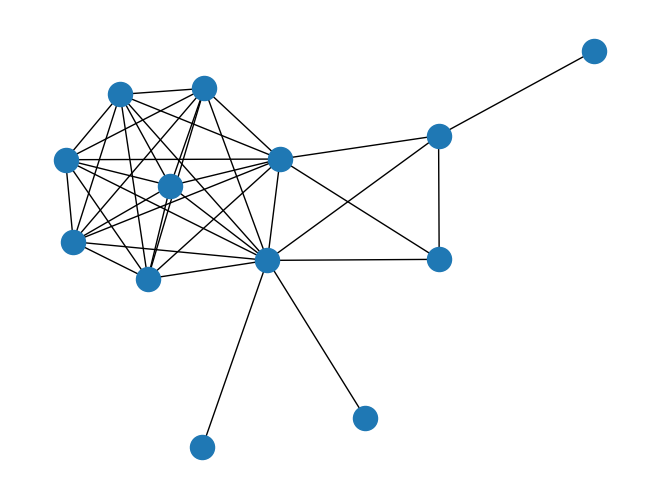

In [80]:
#now for a given datecode, we construct a graph with all alliances active at that time:
def date_filter(dataframe,datecode):
    df=dataframe.reset_index(drop=True,inplace=False)
    for i in range(0,len(df)):
    #filter out alliances that aren't active, ie not dc_st < datecode< dcend
        if not (df['datecode_st'][i]<= datecode<=df['datecode_end'][i]):
            df.drop(i,axis=0,inplace=True)
    df.reset_index(drop=True,inplace=True)
    return df
def graph_constructor(dataframe,datecode):
    df=date_filter(dataframe=dataframe,datecode=datecode)
    edges_df = df.drop(labels=['state_name1','state_name2','defense','entente','datecode_end','datecode_st'],axis=1)
    #this feels stupid, but is probably the easiest way to do this
    edges=[]
    for i in range(0,len(edges_df)):
        edge=(df['ccode1'][i],df['ccode2'][i],{'start':df['datecode_st'][i],'end':df['datecode_end'][i]})
        edges.append(edge)
    alliances=nx.Graph(edges)
    return alliances
#we use country codes for our verticies, to save memory
G= graph_constructor(df,663325.0)
nx.draw_kamada_kawai(G)
#Alliance_graph=nx.Graph()
#we can look up names later using the function defined below

In [ ]:
#create a graph of our allliances, for a given point in time by first filtering for those aliances wich ended before our start time,
# and then those with started after our end time
# we consider defense pacts and entente's as alliances, and ignore all other forms alliance forms, presuming enemies.

#check this

#now we should have a graph of alliances for some date code 
#graph this to check

In [ ]:
#now we can perform stability analysis, we/I (kyle) use the following metrics:
# for each neighbor (ally):
#how many of our neighbors (so the neighbors of neighbors) are enemies with each other (the original neigbors), and how many are allies, how many allies do we have
#ie each vertex(country) has a repulsive force for allying with another country (the numbere of it's current allies that are enemies with said country)
#and a attractive force (number of allies already allied with said country)
#we define functions for returning said forces below

def forces(graph, source_vertex, attracting_vertex):
    allies = graph.neighbors(source_vertex)
    attraction=0
    repulsion=0
    for ally in allies:
        if attracting_vertex in graph.neighbors(ally):
            attraction+=1
        else:
            repulsion+=1
    return attraction, repulsion,len(allies)
#recusive version of above for our k-neighbor's
def k_forces(graph,source_verticies,sink_vertex,k=1):
    allies = graph.neighbors(source_verticies)
    if k<=0:
        for ally in allies:
            if attracting_vertex in graph.neighbors(ally):
                k_attraction+=1
            else:
                k_repulsion+=1
        return k_attraction,k_repulsion,len(allies)
    else:
        k-=1
        k_forces(graph,allies,sink_vertex,k)
#clique analysis:
#WARNING THIS IS NP-COMPLETE AND THEREFORE SLOWS WITH SCALE EXTREMELY FAST
#have we formed a stable clique?, does is the graph either 2 complete subgraphs or a complete graph?

def k_cliques(graph):